<a href="https://colab.research.google.com/github/bcmin1018/NLP/blob/main/review%20score_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://hong-yp-ml-records.tistory.com/102  
https://paperswithcode.com/paper/understanding-back-translation-at-scale  
레이블 잘 섞였는지 확인.
모델 테스트 수정

In [ ]:
!pip install transformers
!pip install soynlp
!pip install googletrans==3.1.0a0

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train
!gdown --id 1LwUsCrYP2BtD2vVIpdezCB4vzbNUsYOr

#test
!gdown --id 1Z9sxHad7bnoR65xWKhNkqaEvCLesPeRp

#sample_submission
!gdown --id 1DAV5cjazlrbVZilO9lBvxf_yg4Gw_grl

train_data_path= "./train.csv"
test_data_path= "./test.csv"
sample_submission_path = "./sample_submission.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
sample_submission = pd.read_csv(sample_submission_path)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1LwUsCrYP2BtD2vVIpdezCB4vzbNUsYOr
To: /content/train.csv
100% 2.74M/2.74M [00:00<00:00, 180MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Z9sxHad7bnoR65xWKhNkqaEvCLesPeRp
To: /content/test.csv
100% 2.68M/2.68M [00:00<00:00, 216MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://dr

In [ ]:
from soynlp.normalizer import emoticon_normalize, only_text
import re

def normalise(df):
     clean=[]
     for text in df.reviews.to_list():
         text = re.sub('\.*!+', '!', text)
         text = re.sub('\.*\?+', '?', text)
         text = re.sub('\.+', '.', text)
         text = re.sub(',+', ',', text)
         text = re.sub('[^A-Za-z0-9가-힣\s\[\].,!?\"\']', '', text)
         text = emoticon_normalize(only_text(text), num_repeats=1)
         text = re.sub('\s+', ' ', text)
         clean.append(text)

     return clean

clean_train = normalise(train_data)
train_data['reviews'] = clean_train

clean_test = normalise(test_data)
test_data['reviews'] = clean_test

In [ ]:
print("train 데이터 길이 : ", len(train_data))
print("test 데이터 길이 : ", len(test_data))
print("sample_submission 데이터 길이 : ", len(sample_submission))

train 데이터 길이 :  25000
test 데이터 길이 :  25000
sample_submission 데이터 길이 :  25000


In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_data, test_size=0.3, stratify=train_data.target, random_state=2022)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [ ]:
print("train 데이터 길이 : ", len(train))
print("valid 데이터 길이 : ", len(valid))

train 데이터 길이 :  17500
valid 데이터 길이 :  7500


In [ ]:
train.target.value_counts()

5    7000
2    5600
1    3150
4    1750
Name: target, dtype: int64

## 데이터 증강

In [ ]:
!pip install --upgrade pip
!git clone https://github.com/kakaobrain/pororo.git
%cd pororo
!pip install -e .

In [ ]:
from pororo import Pororo
pg = Pororo(task="pg", lang="ko")

In [ ]:
import numpy as np
import pandas as pd
import random
import sklearn

def augment_gen(df, samples=300, label=4):
  df = df[['reviews', 'target']]
  new_text = []
  df_n = df[df.target==label].reset_index(drop=True)

  for i in np.random.randint(0, len(df_n), samples):
    text = df_n.iloc[i]['reviews']
    augmented_text = pg(text)
    new_text.append(augmented_text)

  new=pd.DataFrame({'reviews':new_text, 'target':label})
  df=sklearn.utils.shuffle(df.append(new).reset_index(drop=True))
  return df

In [ ]:
train = augment_gen(train, samples=1750, label=4)
train = augment_gen(train, samples=1300, label=1)

In [ ]:
train.to_csv("/content/drive/MyDrive/gen4,1.csv", index=False)

In [ ]:
train.target.value_counts()

5    7000
2    5600
1    4450
4    3500
Name: target, dtype: int64

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/gen4,1.csv")

In [ ]:
train_label_one = train[train.target == 1]
train_label_two = train[train.target == 2]
train_label_four = train[train.target == 4]
train_label_five = train[train.target == 5]

In [ ]:
import googletrans
from googletrans import Translator

def back_translation(text, cnt):
  translator = Translator()
  
  if cnt == 1:
    ja_to_ko = translator.translate(translator.translate(text, src='ko', dest='ja').text, src='ja', dest='ko').text
    return ja_to_ko

  elif cnt >= 2 and cnt < 3:
    ja_to_ko = translator.translate(translator.translate(text, src='ko', dest='ja').text, src='ja', dest='ko').text
    de_to_ko = translator.translate(translator.translate(text, src='ko', dest='de').text, src='de', dest='ko').text
    return ja_to_ko, de_to_ko

  elif cnt >= 3:
    ja_to_ko = translator.translate(translator.translate(text, src='ko', dest='ja').text, src='ja', dest='ko').text
    de_to_ko = translator.translate(translator.translate(text, src='ko', dest='de').text, src='de', dest='ko').text
    fr_to_ko = translator.translate(translator.translate(text, src='ko', dest='fr').text, src='fr', dest='ko').text
    return ja_to_ko, de_to_ko, fr_to_ko

def bt_aug(data, target_num, trans_cnt):
  reviews = []
  for review in data.reviews: #리뷰 데이터
    reviews.extend(back_translation(review, trans_cnt)) #리뷰데이터를 리스트 형태로 받는다
  cnt = len(reviews)
  target = [target_num] * cnt
  add_df = pd.DataFrame({'reviews':reviews, 'target': target})
  return add_df

In [ ]:
reviews = []
for review in train_four.reviews.values: #리뷰 데이터
  reviews.append(back_translation(review, 1))

In [ ]:
cnt = len(reviews)
target = [4] * cnt
train_four_tmp = pd.DataFrame({'reviews':reviews, 'target': target})

In [ ]:
train_tmp = pd.concat([train_four_tmp, train])

In [ ]:
train_tmp.to_csv("/content/drive/MyDrive/last_train.csv", index=False)

In [ ]:
train_tmp = pd.read_csv("/content/drive/MyDrive/last_train.csv")

In [ ]:
import sklearn
train_tmp=sklearn.utils.shuffle(train_tmp)

In [ ]:
train = train_tmp.reset_index(drop=True)

In [ ]:
train.target.value_counts()

4    7000
5    7000
2    5600
1    4450
Name: target, dtype: int64

In [ ]:
train_one = train[train.target == 1]
train_two = train[train.target == 2]
train_four = train[train.target == 4]
train_five = train[train.target == 5]

train_one['target2'] = 0
train_two['target2'] = 0
train_four['target2'] = 1
train_five['target2'] = 1

valid_one = valid[valid.target == 1]
valid_two = valid[valid.target == 2]
valid_four = valid[valid.target == 4]
valid_five = valid[valid.target == 5]

valid_one['target2'] = 0
valid_two['target2'] = 0
valid_four['target2'] = 1
valid_five['target2'] = 1

In [ ]:
train = pd.concat([train_one, train_two, train_four, train_five])
valid = pd.concat([valid_one, valid_two, valid_four, valid_five ])

In [ ]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [ ]:
train_label_one = train_data[train_data.target == 1]
train_label_two = train_data[train_data.target == 2]
train_label_four = train_data[train_data.target == 4]
train_label_five = train_data[train_data.target == 5]

print("train number of target 1:", len(train_label_one))
print("train number of target 2:", len(train_label_two))
print("train number of target 4:", len(train_label_four))
print("train number of target 5:", len(train_label_five))

target_one_df = bt_aug(train_label_one, 1, 2)
target_two_df = bt_aug(train_label_two, 2, 1)
target_four_df = bt_aug(train_label_four, 4, 3)
target_five_df = bt_aug(train_label_five, 5, 1)

In [ ]:
train = pd.concat([target_one_df, target_two_df, target_four_df, target_five_df, train])

In [ ]:
# add_bt.to_csv("/content/drive/MyDrive/train_v4.csv", index=False)
# train_all = pd.read_csv("/content/drive/MyDrive/train_all.csv")
train = pd.read_csv("/content/drive/MyDrive/gen_train.csv")

In [ ]:
train['target'].value_counts()

4    7000
5    7000
2    5600
1    4450
Name: target, dtype: int64

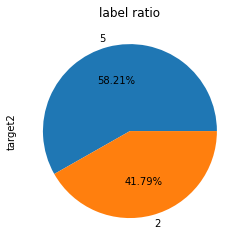

In [ ]:
train['target2'].value_counts().plot.pie(autopct='%0.2f%%',
                                             labels=[5, 2, 1, 4],
                                             title = 'label ratio')

In [ ]:
# config
config = {
    'TRAINER': {
        'seed' : 2022,
        # 'tokenizer' : 'BertTokenizer',
        # 'tokenizer' : 'ElectraTokenizer',
        'tokenizer' : 'AutoTokenizer',
        # 'model' : 'BertForSequenceClassification',
        # 'model' : 'ElectraForSequenceClassification',
        'model' : 'AutoModelForSequenceClassification',
        # 'pretrained' : 'bert-base-multilingual-cased',
        # 'pretrained' : 'monologg/koelectra-small-v2-discriminator',
        'pretrained' : 'klue/roberta-base',
        'optimizer' : 'adamw',
        'learning_rate' : 2e-5,
        'loss' : 'crossentropy',
        'early_stopping_target' : 'val_loss',
        'early_stopping_patience' : 10,
        'early_stopping_mode' : 'min',
        'n_epochs' : 20,
        'weight_decay' : 1e-2
    },
    'DATALOADER': {
      'batch_size' : 32,
      'shuffle' : True,
      'num_workers' : 2  
    }
}

In [ ]:
label_map_dict = {
    1: 0, 
    2: 1, 
    4: 2, 
    5: 3
}

train['target'].replace(label_map_dict, inplace=True)
valid['target'].replace(label_map_dict, inplace=True)

In [ ]:
#utils.py
import torch.optim as optim
from torch.nn import functional as F
import torch.nn as nn

def get_model(model_name:str, pretrained):
    if model_name == 'ElectraForSequenceClassification':
      return ElectraForSequenceClassification.from_pretrained(pretrained, num_labels=4)
    if model_name == 'BertForSequenceClassification':
      return BertForSequenceClassification.from_pretrained(pretrained, num_labels=4)
    if model_name == 'AutoModelForSequenceClassification':
      return AutoModelForSequenceClassification.from_pretrained(pretrained, num_labels=4)

def get_optimizer(optimizer_name: str):

    if optimizer_name == 'sgd':

        return optim.SGD

    elif optimizer_name == 'adam':

        return optim.Adam
    
    elif optimizer_name == 'adamw':

        return optim.AdamW

def get_loss(loss_name: str):
    if loss_name == 'crossentropy':
        return nn.CrossEntropyLoss()

In [ ]:
# dataset.py
from torch.utils.data import Dataset
import torch

class BERTDataset(Dataset):
  def __init__(self, data, tokenizer, max_seq_len, mode = 'train'):
    self.mode = mode
    self.tokenizer = tokenizer
    self.max_seq_len = max_seq_len
    self.data = data
    if mode == 'train':
      self.x = self.data.reviews
      self.y = self.data.target
    else:
      self.x = self.data.reviews

  def __len__(self):
    return len(self.x)

  def __getitem__(self, item):
    x = str(self.x[item])
    x = " ".join(x.split())

    inputs = self.tokenizer.encode_plus(
        x,
        padding='max_length',
        truncation=True,
        max_length = self.max_seq_len
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    if self.mode == 'train':
      return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'target' : torch.tensor(self.y[item], dtype=torch.float)
      }
    else:
      return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
      }

In [ ]:
import numpy as np

class EarlyStopper():

    def __init__(self, patience: int, mode:str):
        self.patience = patience
        self.mode = mode

        # Initiate
        self.patience_counter = 0
        self.stop = False
        self.best_loss = np.inf

        msg = f"Initiated early stopper, mode: {self.mode}, best score: {self.best_loss}, patience: {self.patience}"
        print(msg)
        
    def check_early_stopping(self, loss: float)-> None:
        loss = -loss if self.mode == 'max' else loss  # get max value if mode set to max

        if loss > self.best_loss:
            # got worse score
            self.patience_counter += 1

            msg = f"Early stopper, counter {self.patience_counter}/{self.patience}, best:{abs(self.best_loss)} -> now:{abs(loss)}"
            print(msg)
            
            if self.patience_counter == self.patience:
                msg = f"Early stopper, stop"
                print(msg)
                self.stop = True  # end

        elif loss <= self.best_loss:
            # got better score
            self.patience_counter = 0
            print(f"Early stopper, counter {self.patience_counter}/{self.patience}, best:{abs(self.best_loss)} -> now:{abs(loss)}")
            print(f"Set counter as {self.patience_counter}")
            print(f"Update best score as {abs(loss)}")
            self.best_loss = loss
            
        else:
            print('debug')

In [ ]:
# trainer.py
from time import time
from tqdm import tqdm
import torch


class Trainer():
  def __init__(self, model, optimizer, loss, device, scheduler, tokenizer, interval=150):
    self.model = model
    self.optimizer = optimizer
    self.loss = loss
    self.device = device
    self.scheduler = scheduler
    self.tokenizer = tokenizer
    self.interval = interval
    self.loss_sum = 0
    self.loss_mean = 0
    self.y = list()
    self.y_preds = list()
    self.elapsed_time = 0
    
  def train(self, mode, dataloader, tokenizer, epoch_index=0):

    start_timestamp = time()
    self.model.train() if mode == "train" else self.model.eval()
    print(self.device)
    for batch_index, batch in enumerate(tqdm(dataloader)):
      self.optimizer.zero_grad()
      input_ids = batch['input_ids'].to(self.device)
      token_type_ids = batch['token_type_ids'].to(self.device)
      attention_mask = batch['attention_mask'].to(self.device)
      targets = batch['target'].type(torch.LongTensor).to(self.device)

      outputs = self.model(
        input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids,
        # labels=targets
      )
      # print("model outputs: ", outputs)

      loss = self.loss(outputs, targets)
      # loss = self.loss(outputs.logits, targets)
      

      if mode == 'train':
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

      elif mode in ['val', 'test']:
        for y in targets.detach().cpu().numpy():
          self.y.append(y)
        for y_pred in torch.argmax(outputs, dim=1).detach().cpu().numpy():
        # for y_pred in torch.argmax(outputs.logits, dim=1).detach().cpu().numpy():  
          self.y_preds.append(y_pred)
        pass

      self.loss_sum += loss.item()
      if batch_index % self.interval == 0:
        print("batch: {}/{} loss: {}".format(batch_index, len(dataloader), loss.item()))

    self.loss_mean = self.loss_sum / len(dataloader)
    self.result = pd.DataFrame({'pred': self.y_preds, 'label': self.y})
    end_timestamp = time()
    self.elapsed_time = end_timestamp = start_timestamp

  def clear_history(self):
    self.loss_sum = 0
    self.loss_mean = 0
    self.y_preds = list()
    self.y = list()
    self.elapsed_time = 0


In [ ]:
#custom_model.py
class Classifier(nn.Module):
  def __init__(self, mode):
    super(Classifier, self).__init__()
    self.roberta = AutoModel.from_pretrained('klue/roberta-base')
    self.dropout = nn.Dropout(0.3)
    self.out = nn.Linear(768 , 2)
    self.mode = mode

  def forward(self, input_ids, attention_mask, token_type_ids):
    outputs = self.roberta(
        input_ids,
        attention_mask = attention_mask,
        token_type_ids = token_type_ids
    )
    pooler_output = outputs[1]
    if self.mode == 'train':
      drop = self.dropout(pooler_output)
      logits = self.out(drop)
      return logits
    else:
      logits = self.out(pooler_output)
      return logits

In [ ]:
# train.py
import numpy as np
import random
import torch

from torch.utils.data import DataLoader
from transformers import get_scheduler

torch.manual_seed(config['TRAINER']['seed'])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(config['TRAINER']['seed'])
random.seed(config['TRAINER']['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# tokenizer_dict = {'BertTokenizer': BertTokenizer}
# tokenizer_dict = {'ElectraTokenizer': ElectraTokenizer, }
tokenizer_dict = {'AutoTokenizer': AutoTokenizer}
tokenizer = tokenizer_dict[config['TRAINER']['tokenizer']].from_pretrained(config['TRAINER']['pretrained'])

train_dataset = BERTDataset(train, tokenizer, max_seq_len=80, mode = 'train')
valid_dataset = BERTDataset(valid, tokenizer, max_seq_len=80, mode = 'train')

train_data_loader = DataLoader(train_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=config['DATALOADER']['shuffle'])

valid_data_loader = DataLoader(valid_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=config['DATALOADER']['shuffle'])

# model_name = config['TRAINER']['model']
# model = get_model(model_name=model_name, pretrained=config['TRAINER']['pretrained']).to(device)
model = Classifier("train").to(device)

optimizer = get_optimizer(optimizer_name=config['TRAINER']['optimizer'])
optimizer = optimizer(params=model.parameters(),lr=config['TRAINER']['learning_rate'], weight_decay=config['TRAINER']['weight_decay'])

num_training_steps = config['TRAINER']['n_epochs'] * len(train_data_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

loss = get_loss(loss_name=config['TRAINER']['loss'])

early_stopper = EarlyStopper(patience=config['TRAINER']['early_stopping_patience'],
                                mode=config['TRAINER']['early_stopping_mode'])

trainer = Trainer(model=model,
                      optimizer=optimizer,
                      loss=loss,
                      device=device,
                      scheduler = lr_scheduler,
                      tokenizer=tokenizer,)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Initiated early stopper, mode: min, best score: inf, patience: 10


In [ ]:
# Train
from datetime import datetime, timezone, timedelta
import os
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
writer = SummaryWriter()

PROJECT_DIR = "/content/drive/MyDrive/"
kst = timezone(timedelta(hours=9))
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
os.makedirs(RECORDER_DIR, exist_ok=True)

n_epochs = config['TRAINER']['n_epochs']
for epoch_index in range(n_epochs):
  print(f"Train {epoch_index}/{n_epochs}")
  trainer.train(dataloader=train_data_loader, epoch_index=epoch_index, tokenizer=tokenizer, mode='train')
  print("train loss_mean {} / epoch {}".format(trainer.loss_mean , epoch_index + 1))
  print("train elapsed_time : ", trainer.elapsed_time)
  writer.add_scalar("Loss/train", trainer.loss_mean, epoch_index+1)
  writer.close()
  trainer.clear_history()

  print(f"Val {epoch_index}/{n_epochs}")
  trainer.train(dataloader=valid_data_loader, epoch_index=epoch_index, tokenizer=tokenizer, mode='val')
  print("valid loss_mean {} / epoch {}".format(trainer.loss_mean , epoch_index + 1))
  print("valid elapsed_time : ", trainer.elapsed_time)
  print("valid accuracy_score : ", accuracy_score(trainer.y, trainer.y_preds))
  writer.add_scalar("Accuracy/valid", accuracy_score(trainer.y, trainer.y_preds), epoch_index+1)
  writer.add_scalar("Loss/valid", trainer.loss_mean, epoch_index+1)
  writer.close()


  early_stopping_target = config['TRAINER']['early_stopping_target']
  early_stopper.check_early_stopping(loss=trainer.loss_mean)

  if early_stopper.patience_counter == 0:
      check_point = {
          'epoch': epoch_index + 1,
          'model': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }
      weight_path = os.path.join(RECORDER_DIR, 'model.pt')
      torch.save(check_point, weight_path) 
      print("Recorder, epoch {} Model saved: {}".format(epoch_index + 1, weight_path))
      trainer.result.to_csv(os.path.join(RECORDER_DIR, 'valid_result.csv'), index=False)
  
  if early_stopper.stop == True:
      print(f"Early stopped, counter {early_stopper.patience_counter}/{config['TRAINER']['early_stopping_patience']}")

In [ ]:
train_one = train[train.target == 1]
train_two = train[train.target == 2]
train_four = train[train.target == 4]
train_five = train[train.target == 5]

train_one_two = pd.concat([train_one, train_two]).reset_index(drop=True)
train_four_five = pd.concat([train_four, train_five]).reset_index(drop=True)

valid_one = valid[valid.target == 1]
valid_two = valid[valid.target == 2]
valid_four = valid[valid.target == 4]
valid_five = valid[valid.target == 5]

valid_one_two = pd.concat([valid_one, valid_two]).reset_index(drop=True)
valid_four_five = pd.concat([valid_four, valid_five]).reset_index(drop=True)

label_map_dict = {
    1: 0, 
    2: 1, 
    4: 0, 
    5: 1
}

train_one_two['target'].replace(label_map_dict, inplace=True)
train_four_five['target'].replace(label_map_dict, inplace=True)
valid_one_two['target'].replace(label_map_dict, inplace=True)
valid_four_five['target'].replace(label_map_dict, inplace=True)

In [ ]:
print(len(train_one_two))
print(len(train_four_five))
print(len(valid_one_two))
print(len(valid_four_five))

10050
14000
3750
3750


In [ ]:
train_onetwo_dataset = BERTDataset(train_one_two, tokenizer, max_seq_len=80, mode = 'train')
valid_onetwo_dataset = BERTDataset(valid_one_two, tokenizer, max_seq_len=80, mode = 'train')
train_fourfive_dataset = BERTDataset(train_four_five, tokenizer, max_seq_len=80, mode = 'train')
valid_fourfive_dataset = BERTDataset(valid_four_five, tokenizer, max_seq_len=80, mode = 'train')

train1_data_loader = DataLoader(train_onetwo_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=config['DATALOADER']['shuffle'])

valid1_data_loader = DataLoader(valid_onetwo_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=config['DATALOADER']['shuffle'])

train2_data_loader = DataLoader(train_fourfive_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=config['DATALOADER']['shuffle'])

valid2_data_loader = DataLoader(valid_fourfive_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=config['DATALOADER']['shuffle'])

In [ ]:
model = Classifier("train").to(device)
optimizer = get_optimizer(optimizer_name=config['TRAINER']['optimizer'])
optimizer = optimizer(params=model.parameters(),lr=config['TRAINER']['learning_rate'], weight_decay=config['TRAINER']['weight_decay'])

num_training_steps = config['TRAINER']['n_epochs'] * len(train_data_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

loss = get_loss(loss_name=config['TRAINER']['loss'])

early_stopper = EarlyStopper(patience=config['TRAINER']['early_stopping_patience'],
                                mode=config['TRAINER']['early_stopping_mode'])
trainer = Trainer(model=model,
                      optimizer=optimizer,
                      loss=loss,
                      device=device,
                      scheduler = lr_scheduler,
                      tokenizer=tokenizer,)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Initiated early stopper, mode: min, best score: inf, patience: 10


In [ ]:
# Train
from datetime import datetime, timezone, timedelta
import os
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
writer = SummaryWriter()

PROJECT_DIR = "/content/drive/MyDrive/"
kst = timezone(timedelta(hours=9))
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
os.makedirs(RECORDER_DIR, exist_ok=True)

n_epochs = config['TRAINER']['n_epochs']
for epoch_index in range(n_epochs):
  print(f"Train {epoch_index}/{n_epochs}")
  trainer.train(dataloader=train2_data_loader, epoch_index=epoch_index, tokenizer=tokenizer, mode='train')
  print("train loss_mean {} / epoch {}".format(trainer.loss_mean , epoch_index + 1))
  print("train elapsed_time : ", trainer.elapsed_time)
  writer.add_scalar("Loss/train", trainer.loss_mean, epoch_index+1)
  writer.close()
  trainer.clear_history()

  print(f"Val {epoch_index}/{n_epochs}")
  trainer.train(dataloader=valid2_data_loader, epoch_index=epoch_index, tokenizer=tokenizer, mode='val')
  print("valid loss_mean {} / epoch {}".format(trainer.loss_mean , epoch_index + 1))
  print("valid elapsed_time : ", trainer.elapsed_time)
  print("valid accuracy_score : ", accuracy_score(trainer.y, trainer.y_preds))
  writer.add_scalar("Accuracy/valid", accuracy_score(trainer.y, trainer.y_preds), epoch_index+1)
  writer.add_scalar("Loss/valid", trainer.loss_mean, epoch_index+1)
  writer.close()


  early_stopping_target = config['TRAINER']['early_stopping_target']
  early_stopper.check_early_stopping(loss=trainer.loss_mean)

  if early_stopper.patience_counter == 0:
      check_point = {
          'epoch': epoch_index + 1,
          'model': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }
      weight_path = os.path.join(RECORDER_DIR, 'model.pt')
      torch.save(check_point, weight_path) 
      print("Recorder, epoch {} Model saved: {}".format(epoch_index + 1, weight_path))
      trainer.result.to_csv(os.path.join(RECORDER_DIR, 'valid_result.csv'), index=False)
  
  if early_stopper.stop == True:
      print(f"Early stopped, counter {early_stopper.patience_counter}/{config['TRAINER']['early_stopping_patience']}")

Train 0/20
cuda


  0%|          | 1/438 [00:00<03:37,  2.01it/s]

batch: 0/438 loss: 1.2134243249893188


 34%|███▍      | 151/438 [00:41<01:18,  3.65it/s]

batch: 150/438 loss: 0.3682362735271454


 69%|██████▊   | 301/438 [01:22<00:37,  3.67it/s]

batch: 300/438 loss: 0.2705581784248352


100%|██████████| 438/438 [01:59<00:00,  3.66it/s]


train loss_mean 0.6623436474160517 / epoch 1
train elapsed_time :  1659630800.814682
Val 0/20
cuda


  3%|▎         | 3/118 [00:00<00:14,  7.99it/s]

batch: 0/118 loss: 0.49810028076171875


100%|██████████| 118/118 [00:11<00:00, 10.64it/s]


valid loss_mean 0.5126772492618884 / epoch 1
valid elapsed_time :  1659630920.4024658
valid accuracy_score :  0.7757333333333334
Early stopper, counter 0/10, best:0.6251894728106967 -> now:0.5126772492618884
Set counter as 0
Update best score as 0.5126772492618884
Recorder, epoch 1 Model saved: /content/drive/MyDrive/results/train/20220805_013320/model.pt
Train 1/20
cuda


  0%|          | 1/438 [00:00<03:01,  2.40it/s]

batch: 0/438 loss: 0.3233519196510315


 34%|███▍      | 151/438 [00:41<01:18,  3.67it/s]

batch: 150/438 loss: 0.26756685972213745


 69%|██████▊   | 301/438 [01:22<00:37,  3.66it/s]

batch: 300/438 loss: 0.3717176616191864


100%|██████████| 438/438 [01:59<00:00,  3.66it/s]


train loss_mean 0.4702187289726244 / epoch 2
train elapsed_time :  1659630935.7527676
Val 1/20
cuda


  3%|▎         | 3/118 [00:00<00:14,  8.12it/s]

batch: 0/118 loss: 0.5736215710639954


100%|██████████| 118/118 [00:11<00:00, 10.60it/s]


valid loss_mean 0.5586146279159239 / epoch 2
valid elapsed_time :  1659631055.3818908
valid accuracy_score :  0.7669333333333334
Early stopper, counter 1/10, best:0.5126772492618884 -> now:0.5586146279159239
Train 2/20
cuda


  0%|          | 1/438 [00:00<02:50,  2.56it/s]

batch: 0/438 loss: 0.2195987105369568


 34%|███▍      | 151/438 [00:41<01:18,  3.67it/s]

batch: 150/438 loss: 0.32299062609672546


 69%|██████▊   | 301/438 [01:22<00:37,  3.68it/s]

batch: 300/438 loss: 0.26015180349349976


100%|██████████| 438/438 [01:59<00:00,  3.67it/s]


train loss_mean 0.431693732075087 / epoch 3
train elapsed_time :  1659631066.5358613
Val 2/20
cuda


  3%|▎         | 3/118 [00:00<00:14,  8.08it/s]

batch: 0/118 loss: 0.4497286081314087


100%|██████████| 118/118 [00:11<00:00, 10.61it/s]


valid loss_mean 0.5239430455080534 / epoch 3
valid elapsed_time :  1659631185.9874942
valid accuracy_score :  0.7784
Early stopper, counter 2/10, best:0.5126772492618884 -> now:0.5239430455080534
Train 3/20
cuda


  0%|          | 1/438 [00:00<02:52,  2.54it/s]

batch: 0/438 loss: 0.17534665763378143


 34%|███▍      | 151/438 [00:41<01:18,  3.67it/s]

batch: 150/438 loss: 0.22847044467926025


 69%|██████▊   | 301/438 [01:22<00:37,  3.67it/s]

batch: 300/438 loss: 0.16823643445968628


100%|██████████| 438/438 [01:59<00:00,  3.67it/s]


train loss_mean 0.3686446273384709 / epoch 4
train elapsed_time :  1659631197.1300993
Val 3/20
cuda


  3%|▎         | 3/118 [00:00<00:14,  8.05it/s]

batch: 0/118 loss: 0.5303898453712463


100%|██████████| 118/118 [00:11<00:00, 10.64it/s]


valid loss_mean 0.5793731995558334 / epoch 4
valid elapsed_time :  1659631316.6353369
valid accuracy_score :  0.7605333333333333
Early stopper, counter 3/10, best:0.5126772492618884 -> now:0.5793731995558334
Train 4/20
cuda


  0%|          | 1/438 [00:00<02:48,  2.59it/s]

batch: 0/438 loss: 0.14013363420963287


 34%|███▍      | 151/438 [00:41<01:18,  3.67it/s]

batch: 150/438 loss: 0.03605220839381218


 69%|██████▊   | 301/438 [01:22<00:37,  3.66it/s]

batch: 300/438 loss: 0.02049843966960907


100%|██████████| 438/438 [01:59<00:00,  3.67it/s]


train loss_mean 0.32600507039797905 / epoch 5
train elapsed_time :  1659631327.7522383
Val 4/20
cuda


  3%|▎         | 3/118 [00:00<00:14,  8.13it/s]

batch: 0/118 loss: 0.39261916279792786


100%|██████████| 118/118 [00:11<00:00, 10.64it/s]


valid loss_mean 0.680396537785813 / epoch 5
valid elapsed_time :  1659631447.23151
valid accuracy_score :  0.7802666666666667
Early stopper, counter 4/10, best:0.5126772492618884 -> now:0.680396537785813
Train 5/20
cuda


  0%|          | 1/438 [00:00<02:50,  2.56it/s]

batch: 0/438 loss: 0.02985994890332222


 34%|███▍      | 151/438 [00:41<01:18,  3.66it/s]

batch: 150/438 loss: 0.08862852305173874


 69%|██████▊   | 301/438 [01:22<00:37,  3.67it/s]

batch: 300/438 loss: 0.18469294905662537


100%|██████████| 438/438 [01:59<00:00,  3.67it/s]


train loss_mean 0.31378563765019657 / epoch 6
train elapsed_time :  1659631458.3518655
Val 5/20
cuda


  2%|▏         | 2/118 [00:00<00:17,  6.81it/s]

batch: 0/118 loss: 0.7577027678489685


100%|██████████| 118/118 [00:11<00:00, 10.60it/s]


valid loss_mean 0.7611844838928368 / epoch 6
valid elapsed_time :  1659631577.846276
valid accuracy_score :  0.7757333333333334
Early stopper, counter 5/10, best:0.5126772492618884 -> now:0.7611844838928368
Train 6/20
cuda


  0%|          | 1/438 [00:00<02:53,  2.52it/s]

batch: 0/438 loss: 0.07606491446495056


  9%|▊         | 38/438 [00:10<01:53,  3.52it/s]


KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
# 긍부정 분류모델
import pandas as pd
import os
test_dataset = BERTDataset(test_data, tokenizer, max_seq_len=80, mode = 'test')
test_data_loader = DataLoader(test_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=False)
# model_name = config['TRAINER']['model']
# model = get_model(model_name=model_name, pretrained=config['TRAINER']['pretrained']).to(device)
model = Classifier("test").to(device)
checkpoint = torch.load("/content/drive/MyDrive/results/train/20220805_010723/model1.pt")
# checkpoint = torch.load(os.path.join(RECORDER_DIR, 'model.pt'))
model.load_state_dict(checkpoint['model'])
model.eval()

y_pred = []
for batch_index, batch in enumerate(tqdm(test_data_loader, leave=True)):
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  token_type_ids = batch['token_type_ids'].to(device)
  outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
  for output in torch.argmax(outputs, dim=1).detach().cpu().numpy():
    y_pred.append(output)

test_data['target'] = y_pred

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [ ]:
test_data

,id,reviews,target
0,0,채소가 약간 시들어 있어요,0
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,0
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,1
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?,0
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,0
...,...,...,...
24995,24995,사용해보니 좋아요,1
24996,24996,저렴한가격에. 질좋고. 핏좋고. 너무. 이쁘게. 입고다녀요.,1
24997,24997,세트상품이라고 써있어서 그런줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 그러네...,0
24998,24998,역시 로네펠트! 좋아요.,1


In [ ]:
test_data_neg = test_data[test_data.target == 0].reset_index(drop=True)
test_data_pos = test_data[test_data.target == 1].reset_index(drop=True)

test_dataset_pos = BERTDataset(test_data_pos, tokenizer, max_seq_len=80, mode = 'test')
test_dataset_neg = BERTDataset(test_data_neg, tokenizer, max_seq_len=80, mode = 'test')
test_data_pos_loader = DataLoader(test_dataset_pos, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=False)
test_data_neg_loader = DataLoader(test_dataset_neg, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=False)

In [ ]:
model = Classifier("train").to(device)
optimizer = get_optimizer(optimizer_name=config['TRAINER']['optimizer'])
optimizer = optimizer(params=model.parameters(),lr=config['TRAINER']['learning_rate'], weight_decay=config['TRAINER']['weight_decay'])

num_training_steps = config['TRAINER']['n_epochs'] * len(train_data_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

loss = get_loss(loss_name=config['TRAINER']['loss'])

early_stopper = EarlyStopper(patience=config['TRAINER']['early_stopping_patience'],
                                mode=config['TRAINER']['early_stopping_mode'])
trainer = Trainer(model=model,
                      optimizer=optimizer,
                      loss=loss,
                      device=device,
                      scheduler = lr_scheduler,
                      tokenizer=tokenizer,)

checkpoint = torch.load("/content/drive/MyDrive/results/train/20220805_012618/model2.pt")
# checkpoint = torch.load(os.path.join(RECORDER_DIR, 'model.pt'))
model.load_state_dict(checkpoint['model'])
model.eval()

y_pred = []
for batch_index, batch in enumerate(tqdm(test_data_pos_loader, leave=True)):
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  token_type_ids = batch['token_type_ids'].to(device)
  outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
  for output in torch.argmax(outputs, dim=1).detach().cpu().numpy():
    y_pred.append(output)

test_data_pos['target2'] = y_pred

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Initiated early stopper, mode: min, best score: inf, patience: 10


100%|██████████| 396/396 [00:35<00:00, 11.15it/s]


In [ ]:
model = Classifier("train").to(device)
optimizer = get_optimizer(optimizer_name=config['TRAINER']['optimizer'])
optimizer = optimizer(params=model.parameters(),lr=config['TRAINER']['learning_rate'], weight_decay=config['TRAINER']['weight_decay'])

num_training_steps = config['TRAINER']['n_epochs'] * len(train_data_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

loss = get_loss(loss_name=config['TRAINER']['loss'])

early_stopper = EarlyStopper(patience=config['TRAINER']['early_stopping_patience'],
                                mode=config['TRAINER']['early_stopping_mode'])
trainer = Trainer(model=model,
                      optimizer=optimizer,
                      loss=loss,
                      device=device,
                      scheduler = lr_scheduler,
                      tokenizer=tokenizer,)

checkpoint = torch.load("/content/drive/MyDrive/results/train/20220804_133730/model3.pt")
# checkpoint = torch.load(os.path.join(RECORDER_DIR, 'model.pt'))
model.load_state_dict(checkpoint['model'])
model.eval()

y_pred = []
for batch_index, batch in enumerate(tqdm(test_data_neg_loader, leave=True)):
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  token_type_ids = batch['token_type_ids'].to(device)
  outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
  for output in torch.argmax(outputs, dim=1).detach().cpu().numpy():
    y_pred.append(output)

test_data_neg['target2'] = y_pred

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Initiated early stopper, mode: min, best score: inf, patience: 10


100%|██████████| 386/386 [00:35<00:00, 10.97it/s]


In [ ]:
test_data_neg.target2.value_counts()

1    7534
0    4806
Name: target2, dtype: int64

In [ ]:
neg_label_map_dict = {
    0: 1, 
    1: 2
}
pos_label_map_dict = {
    0: 4, 
    1: 5, 
}
test_data_pos['target2'].replace(pos_label_map_dict, inplace=True)
test_data_neg['target2'].replace(neg_label_map_dict, inplace=True)

In [ ]:
train_result = pd.concat([test_data_neg, test_data_pos])

In [ ]:
train_result = train_result.sort_values(by=['id']).reset_index(drop=True)

In [ ]:
train_result.target2.value_counts()

5    12111
2     7534
1     4806
4      549
Name: target2, dtype: int64

In [ ]:
pred_df = pd.read_csv(sample_submission_path)
pred_df['target'] = train_result['target2']

In [ ]:
pred_df.to_csv("/content/drive/MyDrive/results/prediction.csv", index=False)

In [ ]:
# Predict
import pandas as pd
import os
test_dataset = BERTDataset(test_data, tokenizer, max_seq_len=80, mode = 'test')
test_data_loader = DataLoader(test_dataset, 
                               batch_size=config['DATALOADER']['batch_size'],
                               num_workers=config['DATALOADER']['num_workers'],
                               shuffle=False)
# model_name = config['TRAINER']['model']
# model = get_model(model_name=model_name, pretrained=config['TRAINER']['pretrained']).to(device)
model = Classifier("test").to(device)
checkpoint = torch.load("/content/drive/MyDrive/results/train/20220803_023844/model.pt")
# checkpoint = torch.load(os.path.join(RECORDER_DIR, 'model.pt'))
model.load_state_dict(checkpoint['model'])
model.eval()
pred_df = pd.read_csv(sample_submission_path)
y_pred = []
for batch_index, batch in enumerate(tqdm(test_data_loader, leave=True)):
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  token_type_ids = batch['token_type_ids'].to(device)
  outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
  for output in torch.argmax(outputs, dim=1).detach().cpu().numpy():
    y_pred.append(output)


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [ ]:
pred_df['target'] = y_pred

In [ ]:
label_map_dict = {
    0: 1, 
    1: 2, 
    2: 4, 
    3: 5
}
pred_df['target'].replace(label_map_dict, inplace=True)
# pred_df.to_csv(os.path.join(RECORDER_DIR, 'prediction.csv'), index=False)
pred_df.to_csv("/content/drive/MyDrive/results/train/20220803_013642/prediction.csv", index=False)

In [ ]:
pred_df['target'].value_counts()

5    12111
2     7534
1     4806
4      549
Name: target, dtype: int64

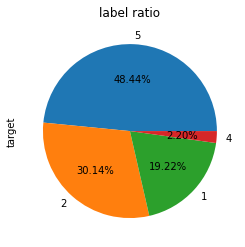

In [ ]:
pred_df['target'].value_counts().plot.pie(autopct='%0.2f%%',
                                             labels=[5, 2, 1, 4],
                                             title = 'label ratio')